## Séries temporais não-estacionárias: ARIMA

Este notebook busca uma série temporal de um arquivo escolhido e faz algumas análises preliminares, bem como a aplicação dos modelos ARIMA.

Data da última atualização: 10/03/2025

#### Preliminares

In [1]:
# Carregamento das bibliotecas

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Ajuste das preferências gráficas

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#FFFFFF',    # Cor da moldura
    'axes.facecolor': '#FFFFFF',      # Cor do fundo
    'savefig.facecolor':'#000000',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': True,
    'grid.color': '#888888',
    'grid.linewidth': '0.1',
    'text.color': '#000000',
    'axes.labelcolor': '#000000',
    'xtick.color': '#000000',
    'ytick.color': '#000000',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (21,13)

#### Carregamento da Série Temporal

In [3]:
# Leitura do arquivo de dados

MinhaSerieTemporal = pd.read_csv('Passageiros.csv', index_col = 0)

In [4]:
# Exibição do DataFrame

MinhaSerieTemporal

,Passageiros (milhares)
Mês,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [5]:
# Ajuste do índice para formato DateTime

MinhaSerieTemporal.index = pd.to_datetime(MinhaSerieTemporal.index)

<Axes: xlabel='Mês'>

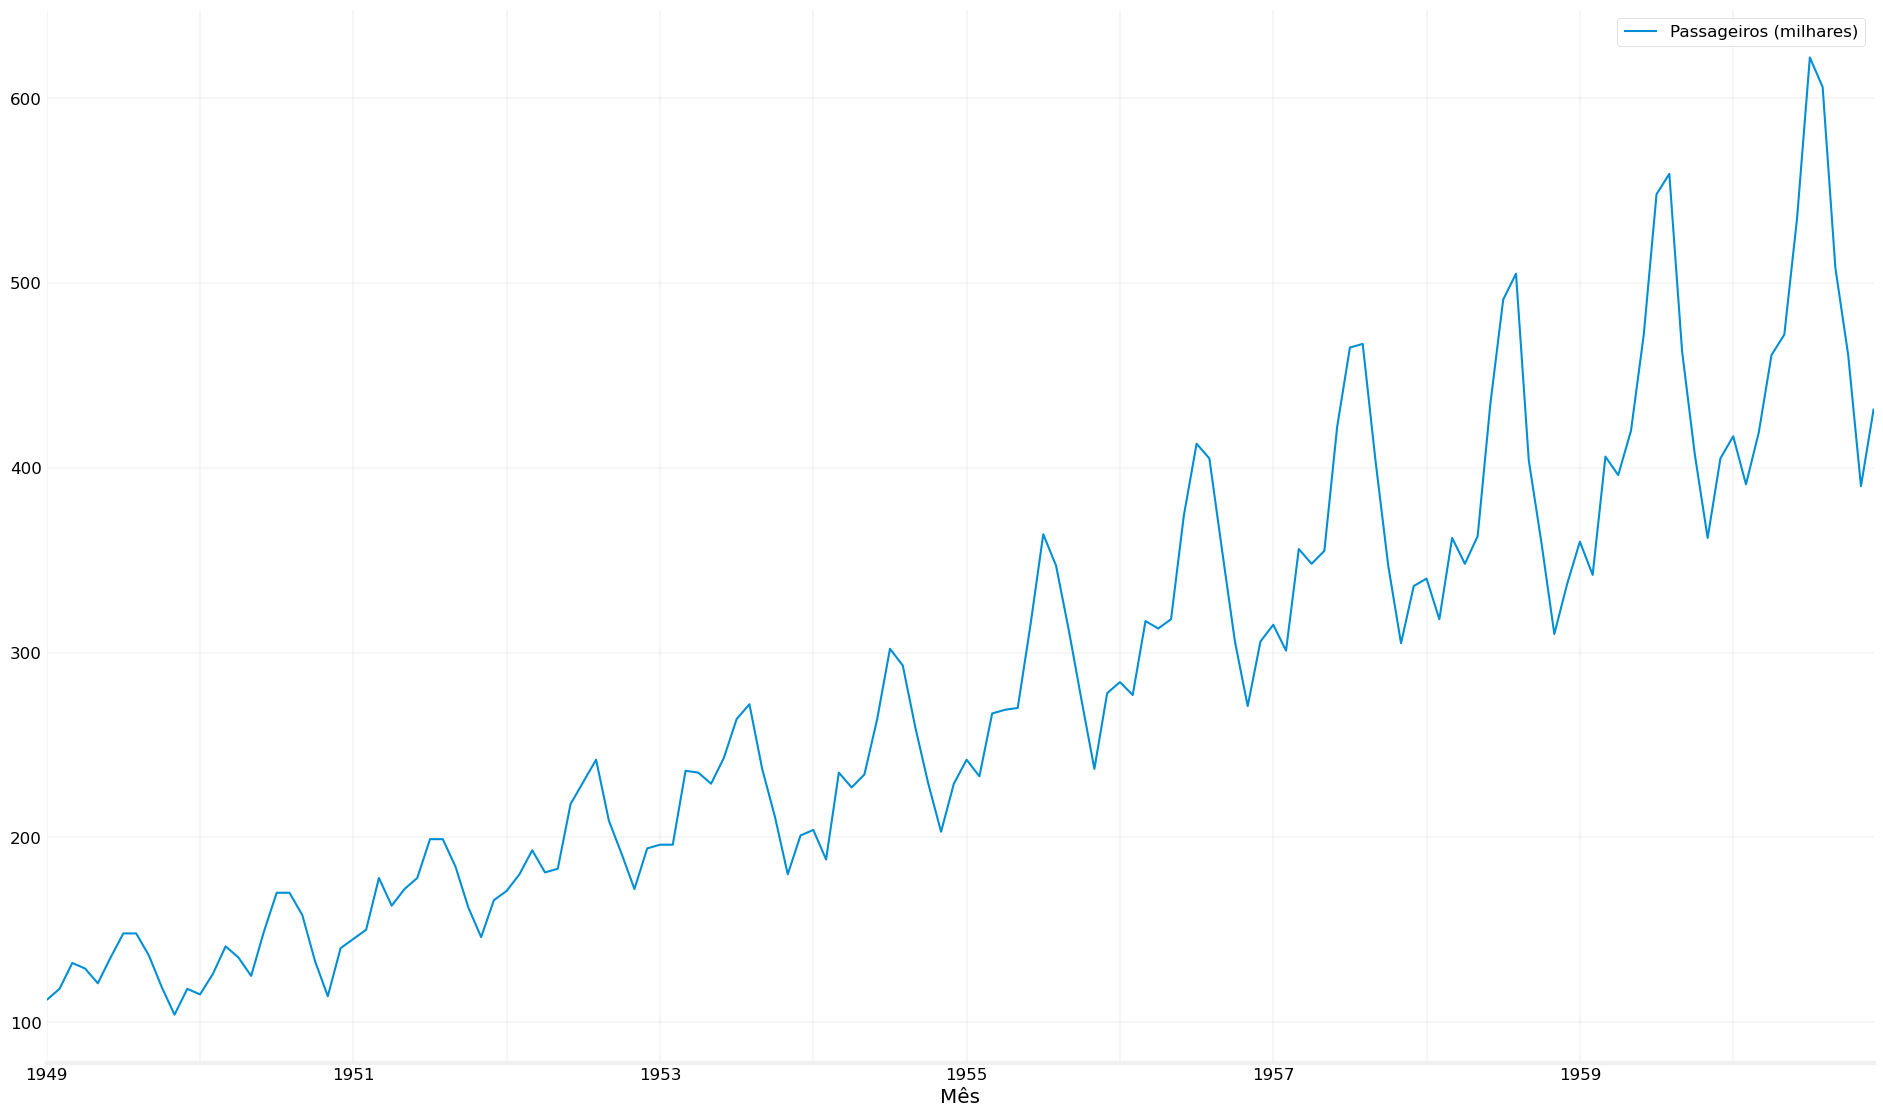

In [6]:
# Gráfico
MinhaSerieTemporal.plot()

#### Decomposição da Série

In [7]:
# Decomposição aditiva da série temporal

PeriodoSazonal = 12     # Sazonalidade anual

Decomposicao = seasonal_decompose(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]], model = "add", period = PeriodoSazonal)

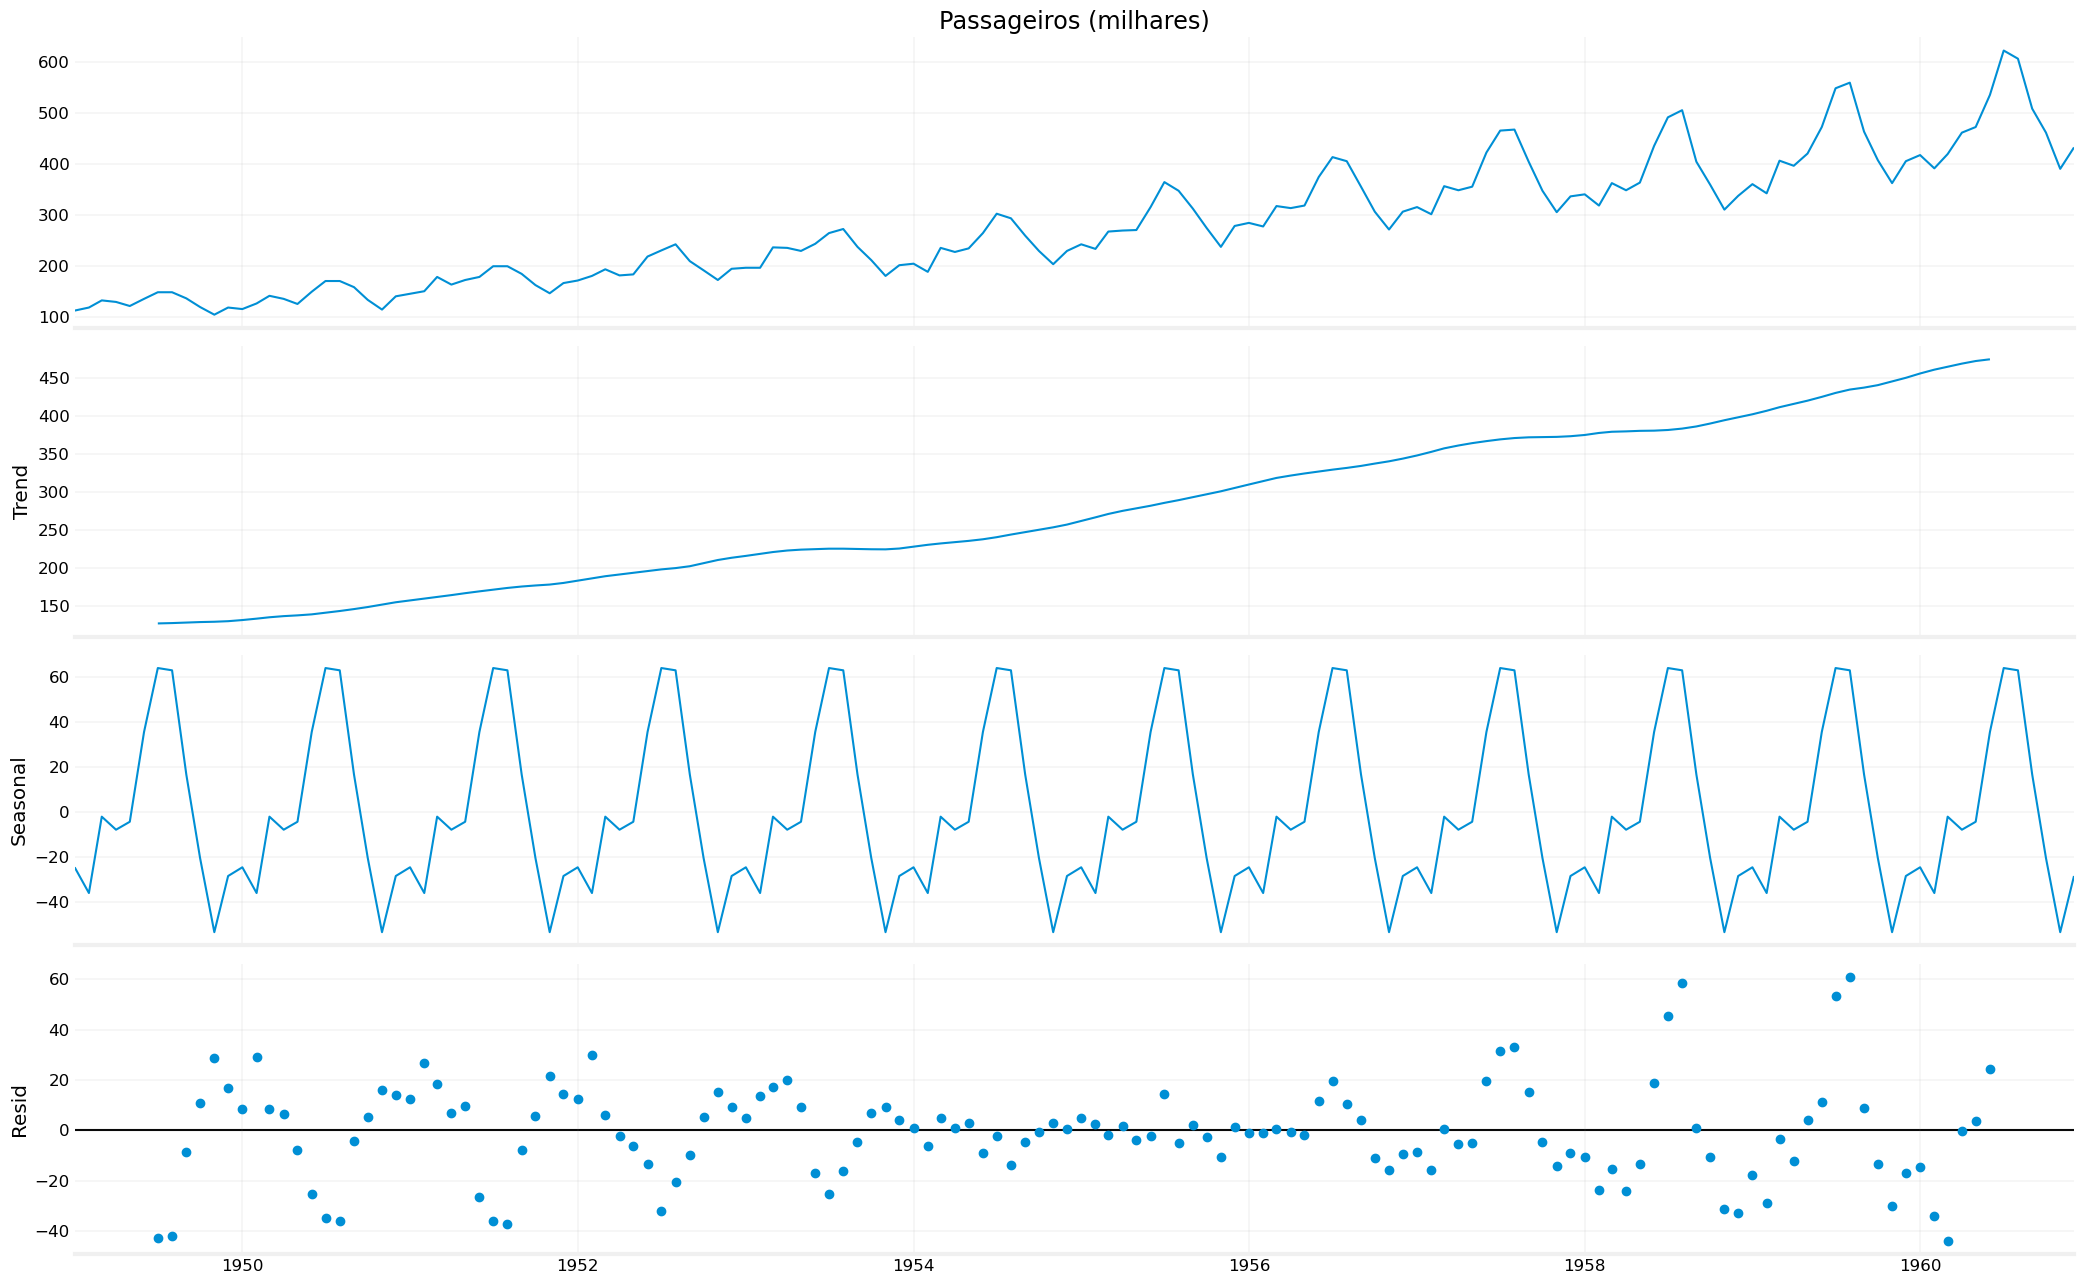

In [8]:
Decomposicao.plot();

#### Teste ADF

In [9]:
# Teste ADF para estacionariedade

ad_fuller_result = adfuller(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]])

print(f'Estatística ADF: {ad_fuller_result[0]:2.4f}')
print(f'p-value:         {ad_fuller_result[1]*100: 2.4f} %')

Estatística ADF: 0.8154
p-value:          99.1880 %


In [10]:
# Teste ADF para estacionariedade para a série das diferenças finitas de ordem escolhida

OrdemDif = 1

ad_fuller_result = adfuller(np.diff(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]], n = OrdemDif))

print(f'Estatística ADF: {ad_fuller_result[0]:2.4f}')
print(f'p-value:         {ad_fuller_result[1]*100: 2.4f} %')

Estatística ADF: -2.8293
p-value:          5.4213 %


In [11]:
# Teste ADF para estacionariedade para a série das diferenças finitas de ordem escolhida

OrdemDif = 2

ad_fuller_result = adfuller(np.diff(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]], n = OrdemDif))

print(f'Estatística ADF: {ad_fuller_result[0]:2.4f}')
print(f'p-value:         {ad_fuller_result[1]*100: 2.4f} %')

Estatística ADF: -16.3842
p-value:          0.0000 %


#### Funcão de autocorrelação

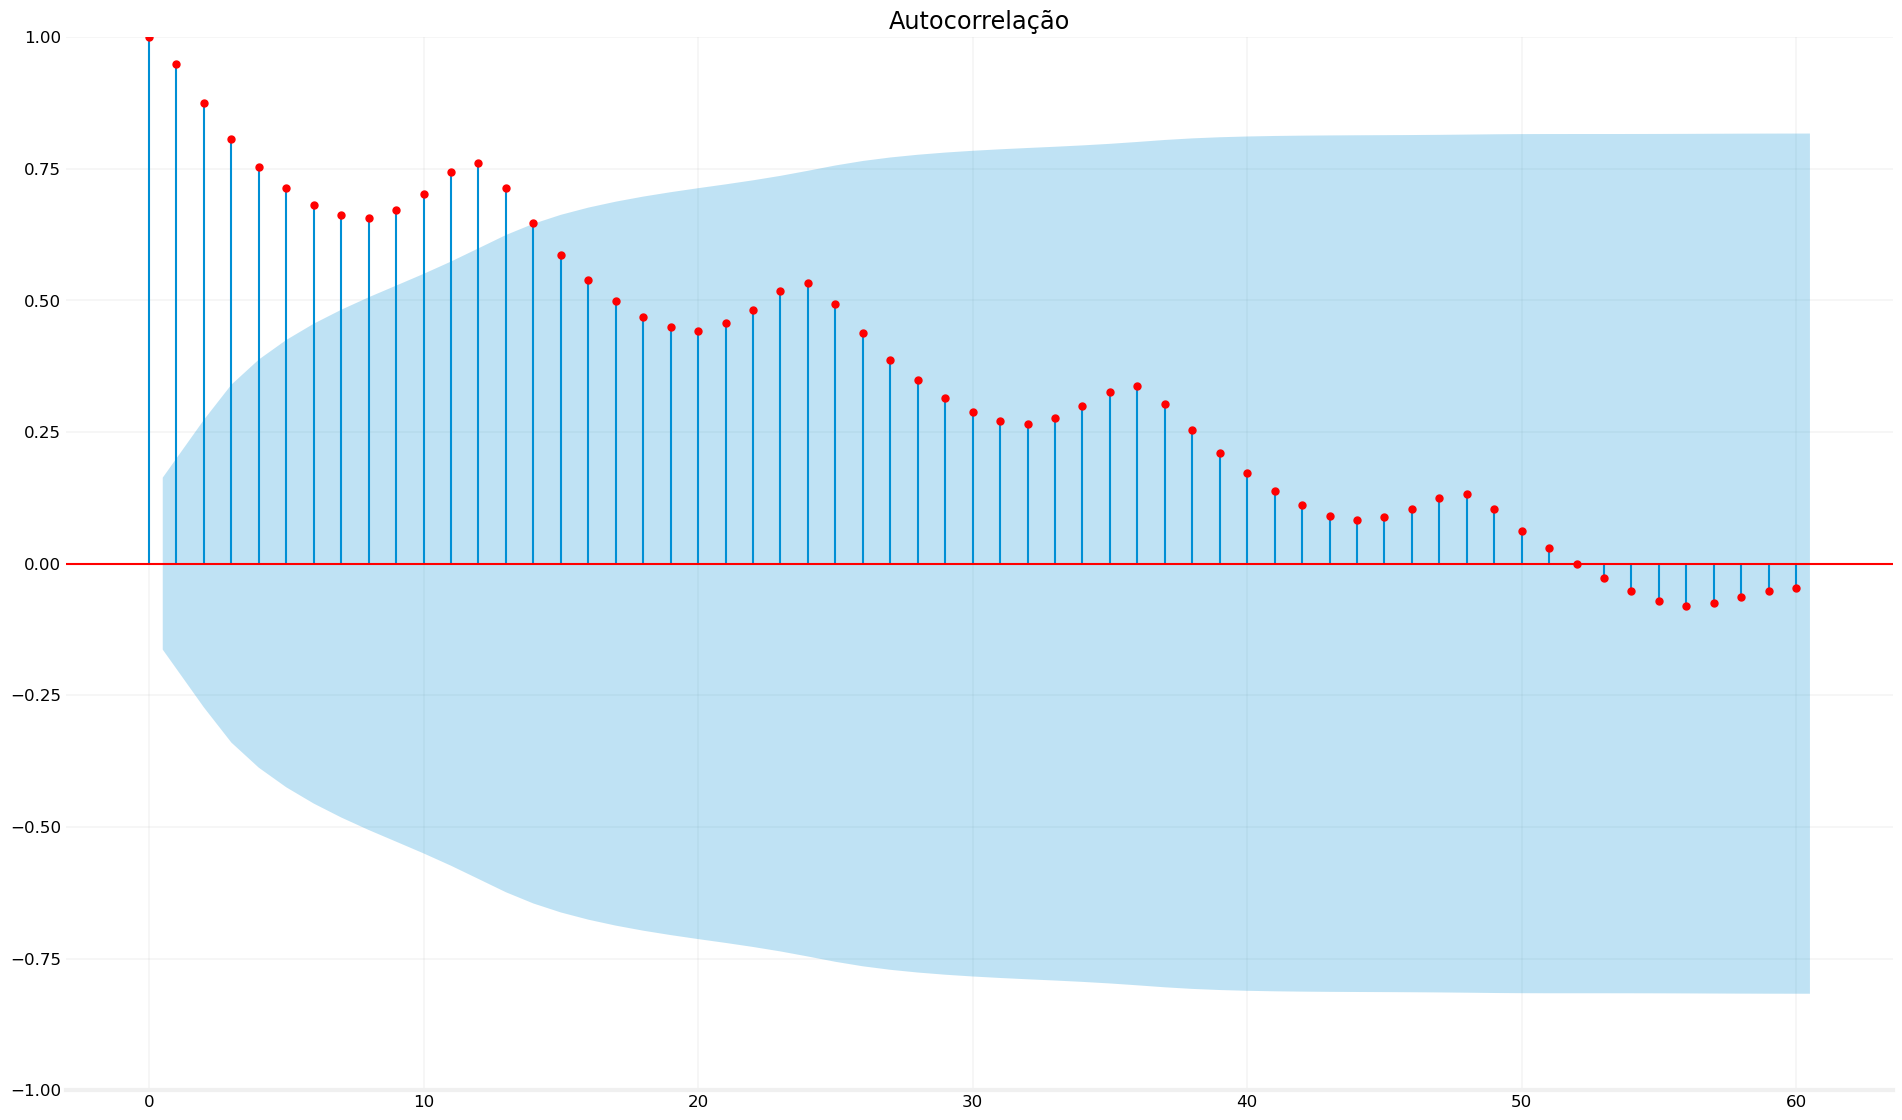

In [12]:
# Função de correlação para série temporal

plot_acf(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]],  lags=60, title = "Autocorrelação", color="red");

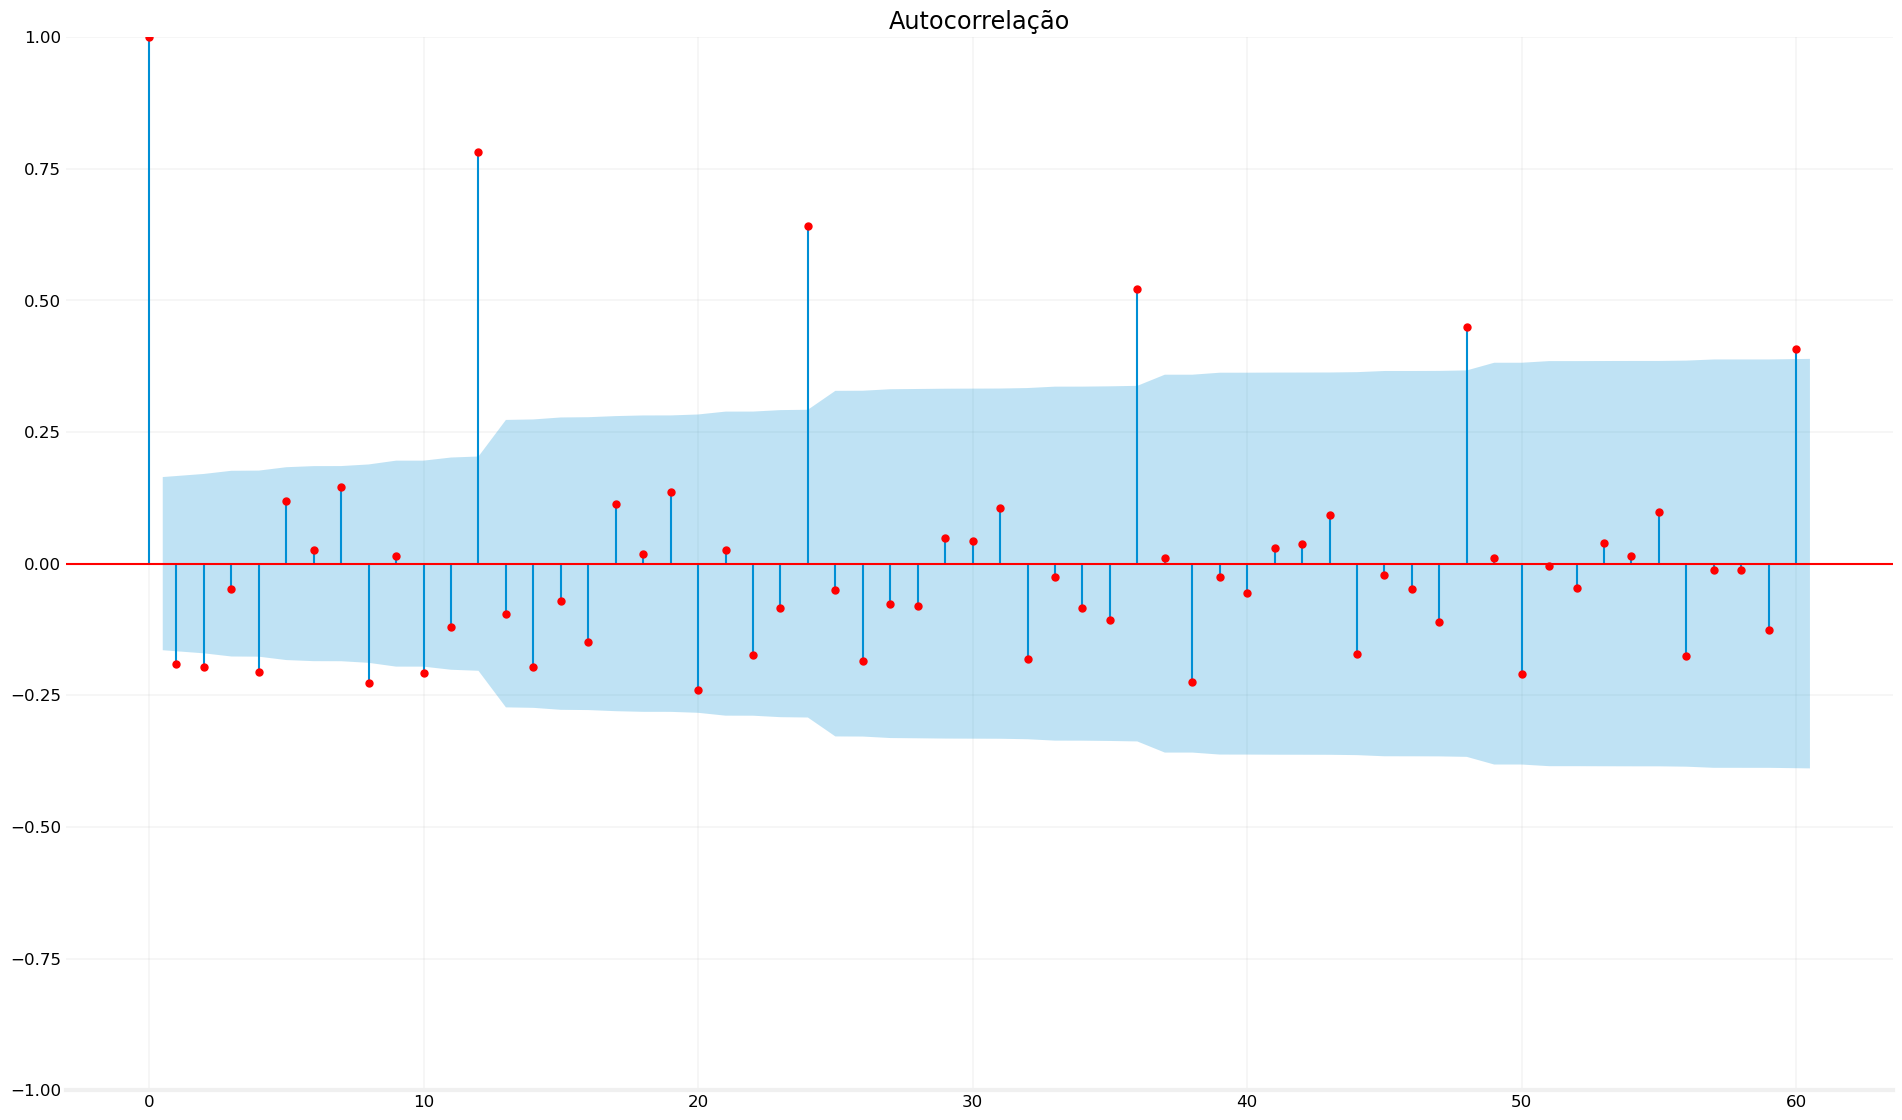

In [13]:
# Função de correlação para série das diferenças finitas da ordem escolhida acima

plot_acf(np.diff(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]], n = OrdemDif),  lags=60, title = "Autocorrelação", color="red");

#### Funcão de autocorrelação parcial

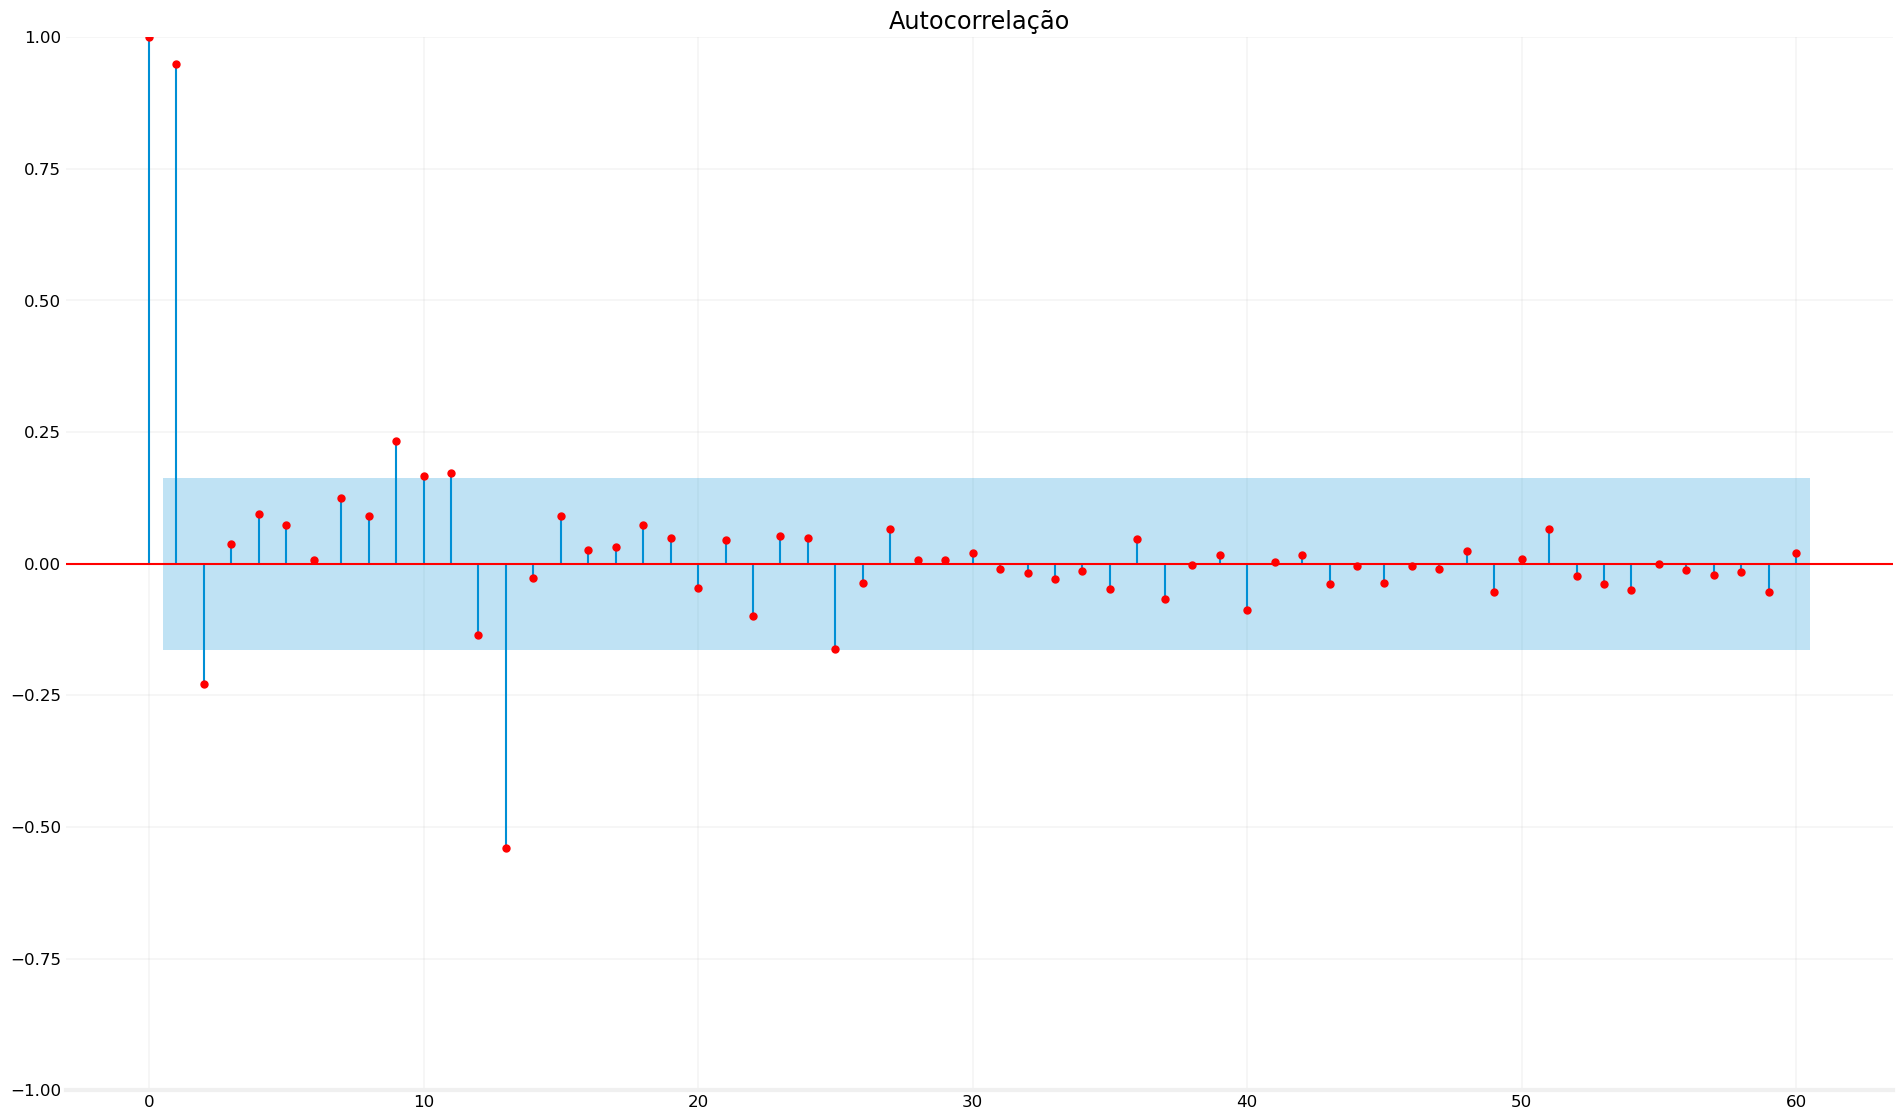

In [14]:
# Função de correlação parcial para série temporal

plot_pacf(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]],  lags=60, title = "Autocorrelação", color="red");

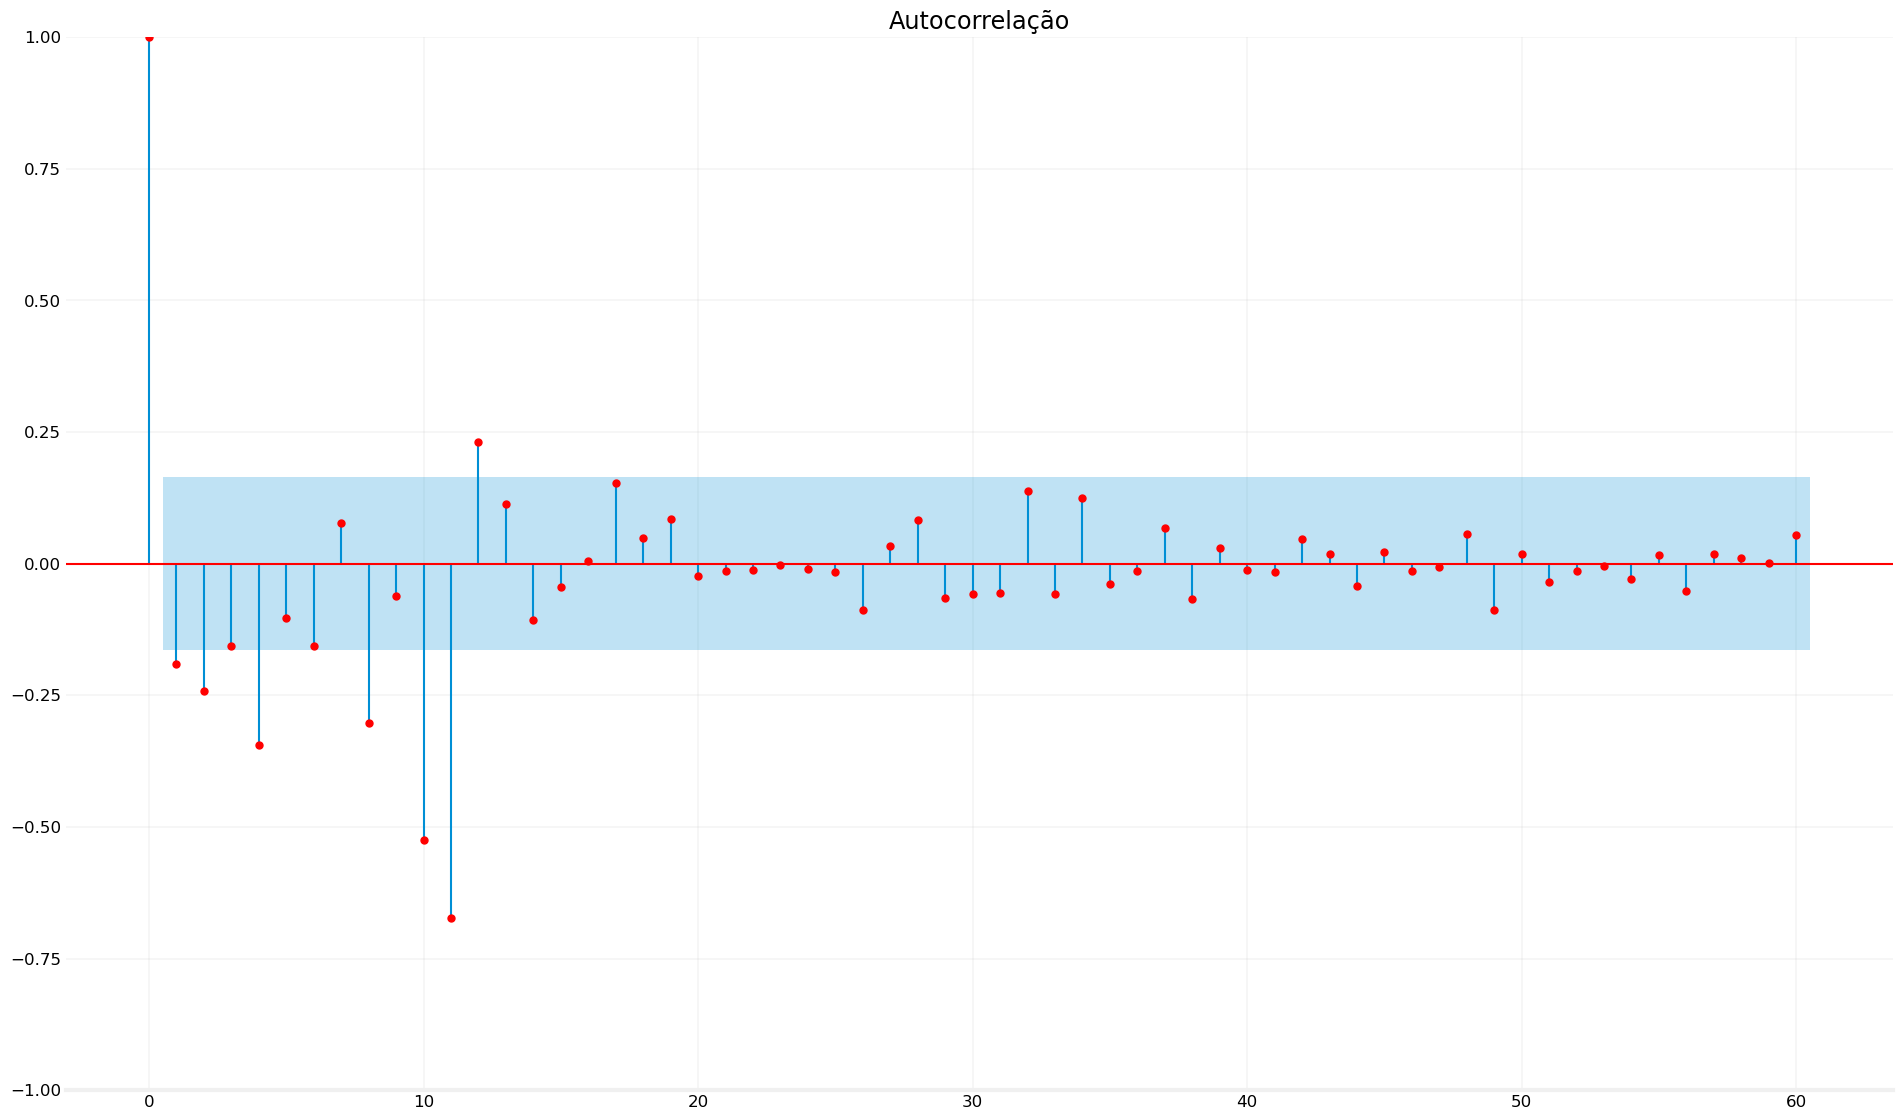

In [15]:
# Função de correlação parcial para série das diferenças finitas da ordem escolhida acima

plot_pacf(np.diff(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]], n = OrdemDif),  lags=60, title = "Autocorrelação", color="red");

#### Separação das bases de treino e teste

In [16]:
# Definição da proporção de dados para compor a base de teste

PercentualTeste = 10

In [17]:
# Cálculo do tamanho do período de testes
PeriodoTeste = PercentualTeste * len(MinhaSerieTemporal) // 100

# Definição do DataFrame de treino
TreinoDF = pd.DataFrame(index = MinhaSerieTemporal[:-PeriodoTeste].index)
TreinoDF['Treino'] = MinhaSerieTemporal[:-PeriodoTeste][MinhaSerieTemporal.columns[0]]

# Definição do DataFrame de teste
TesteDF  = pd.DataFrame(index = MinhaSerieTemporal[-PeriodoTeste:].index)
TesteDF['Teste'] = MinhaSerieTemporal[-PeriodoTeste:][MinhaSerieTemporal.columns[0]]

<Axes: xlabel='Mês'>

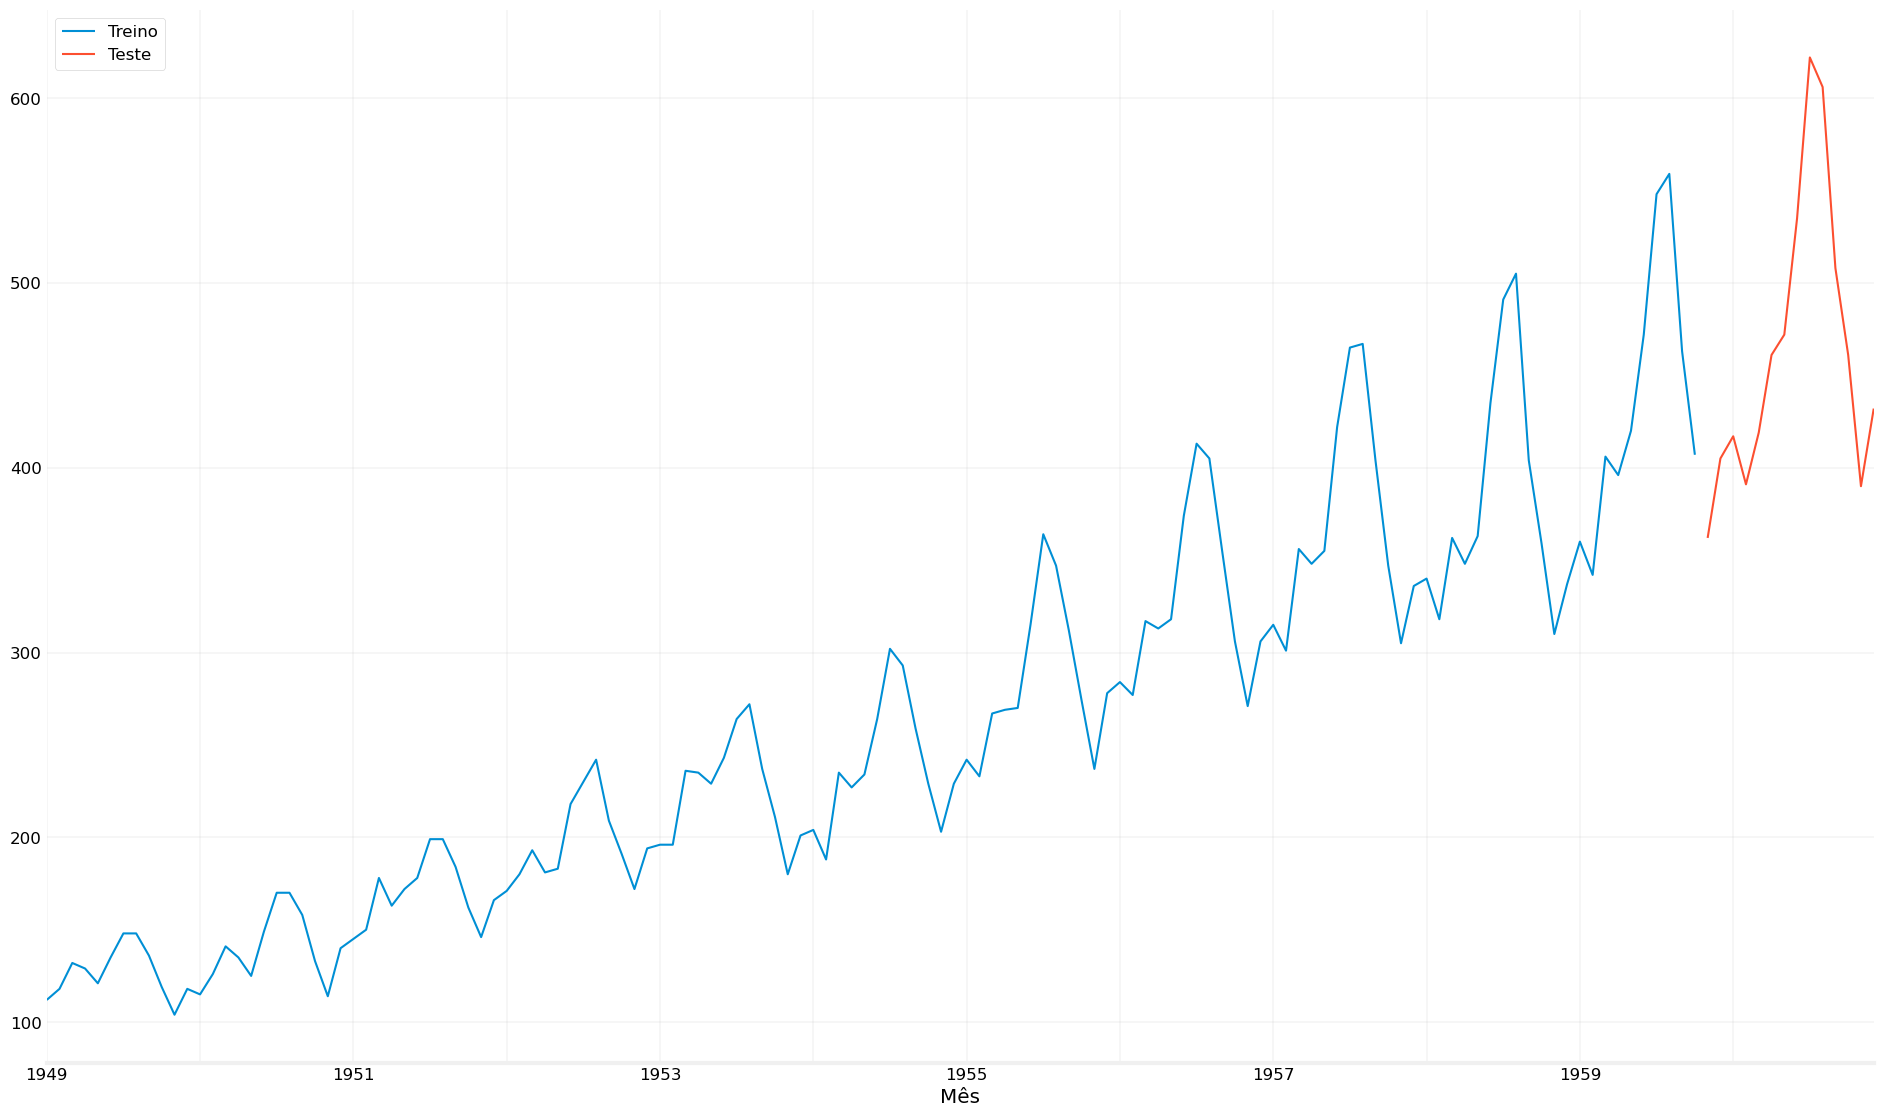

In [18]:
# Exibe a série temporal, com a separação da base de dados

pd.concat([TreinoDF,TesteDF], axis = 1).plot()

#### Previsão pelo modelo ARIMA

In [19]:
# Definição da ordem de autorregressividade
p = 36

# Definição da ordem de integração
d = 2

# Definição da ordem da média móvel
q = 6

In [20]:
InstanteInicial = dt.datetime.now()
model = SARIMAX(TreinoDF, order=(p,d,q))
model_fit = model.fit()
InstanteFinal = dt.datetime.now()

C:\Users\gabri\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\gabri\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\gabri\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\gabri\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\gabri\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum L

In [21]:
print(f'Tempo gasto com o modelo ARIMA: {str(InstanteFinal - InstanteInicial)}')

Tempo gasto com o modelo ARIMA: 0:00:11.761689


In [22]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Treino   No. Observations:                  130
Model:              SARIMAX(36, 2, 6)   Log Likelihood                -471.840
Date:                Sat, 03 May 2025   AIC                           1029.680
Time:                        23:30:52   BIC                           1152.317
Sample:                    01-01-1949   HQIC                          1079.508
                         - 10-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7175      0.471     -1.525      0.127      -1.640       0.205
ar.L2          0.0085      0.697      0.012      0.990      -1.358       1.375
ar.L3          0.0896      0.654      0.137      0.891      -1.192       1.372
ar.L4         -0.2239      0.548     -0.409      0.683      -1.298       0.850
ar.L5         -0.3638      0.609     -0.598      0.550      -1.556       0.829
ar.L6         -0.2534      0.572     -0.443      0.658      -1.374       0.868
ar.L7         -0.2767      0.552     -0.501      0.616      -1.359       0.805
ar.L8         -0.4731      0.585     -0.809      0.419      -1.619       0.673
ar.L9         -0.3641      0.678     -0.537      0.591      -1.693       0.965
ar.L10        -0.4695      0.699     -0.671      0.502      -1.840       0.901
ar.L11        -0.4361      0.723     -0.603      0.547      -1.854       0.982
ar.L12         0.3981      0.738      0.539      0.590      -1.048       1.845
ar.L13         0.2956      0.715      0.413      0.679      -1.106       1.697
ar.L14        -0.3944      0.729     -0.541      0.589      -1.823       1.035
ar.L15        -0.5117      0.781     -0.655      0.512      -2.042       1.019
ar.L16        -0.4358      0.773     -0.564      0.573      -1.951       1.079
ar.L17        -0.2821      0.722     -0.390      0.696      -1.698       1.134
ar.L18        -0.3625      0.554     -0.655      0.513      -1.447       0.722
ar.L19        -0.2012      0.589     -0.341      0.733      -1.356       0.954
ar.L20        -0.1906      0.557     -0.342      0.732      -1.282       0.901
ar.L21        -0.2580      0.550     -0.469      0.639      -1.337       0.821
ar.L22        -0.2452      0.520     -0.472      0.637      -1.264       0.774
ar.L23         0.1597      0.530      0.301      0.763      -0.879       1.199
ar.L24         0.2233      0.514      0.434      0.664      -0.785       1.231
ar.L25        -0.1603      0.495     -0.324      0.746      -1.131       0.810
ar.L26        -0.2907      0.505     -0.575      0.565      -1.281       0.700
ar.L27        -0.1841      0.452     -0.408      0.684      -1.069       0.701
ar.L28        -0.0127      0.444     -0.029      0.977      -0.883       0.858
ar.L29         0.0572      0.344      0.167      0.868      -0.616       0.731
ar.L30        -0.0672      0.328     -0.205      0.838      -0.710       0.576
ar.L31        -0.1225      0.315     -0.389      0.697      -0.739       0.494
ar.L32        -0.0137      0.303     -0.045      0.964      -0.607       0.580
ar.L33         0.0143      0.220      0.065      0.948      -0.418       0.446
ar.L34         0.0269      0.213      0.126      0.900      -0.391       0.445
ar.L35        -0.3003      0.256     -1.175      0.240      -0.801       0.201
ar.L36        -0.3522      0.224     -1.572      0.116      -0.791       0.087
ma.L1         -0.4160      0.481     -0.864      0.387      -1.359       0.527
ma.L2         -0.6866      0.713     -0.963      0.336      -2.084       0.711
ma

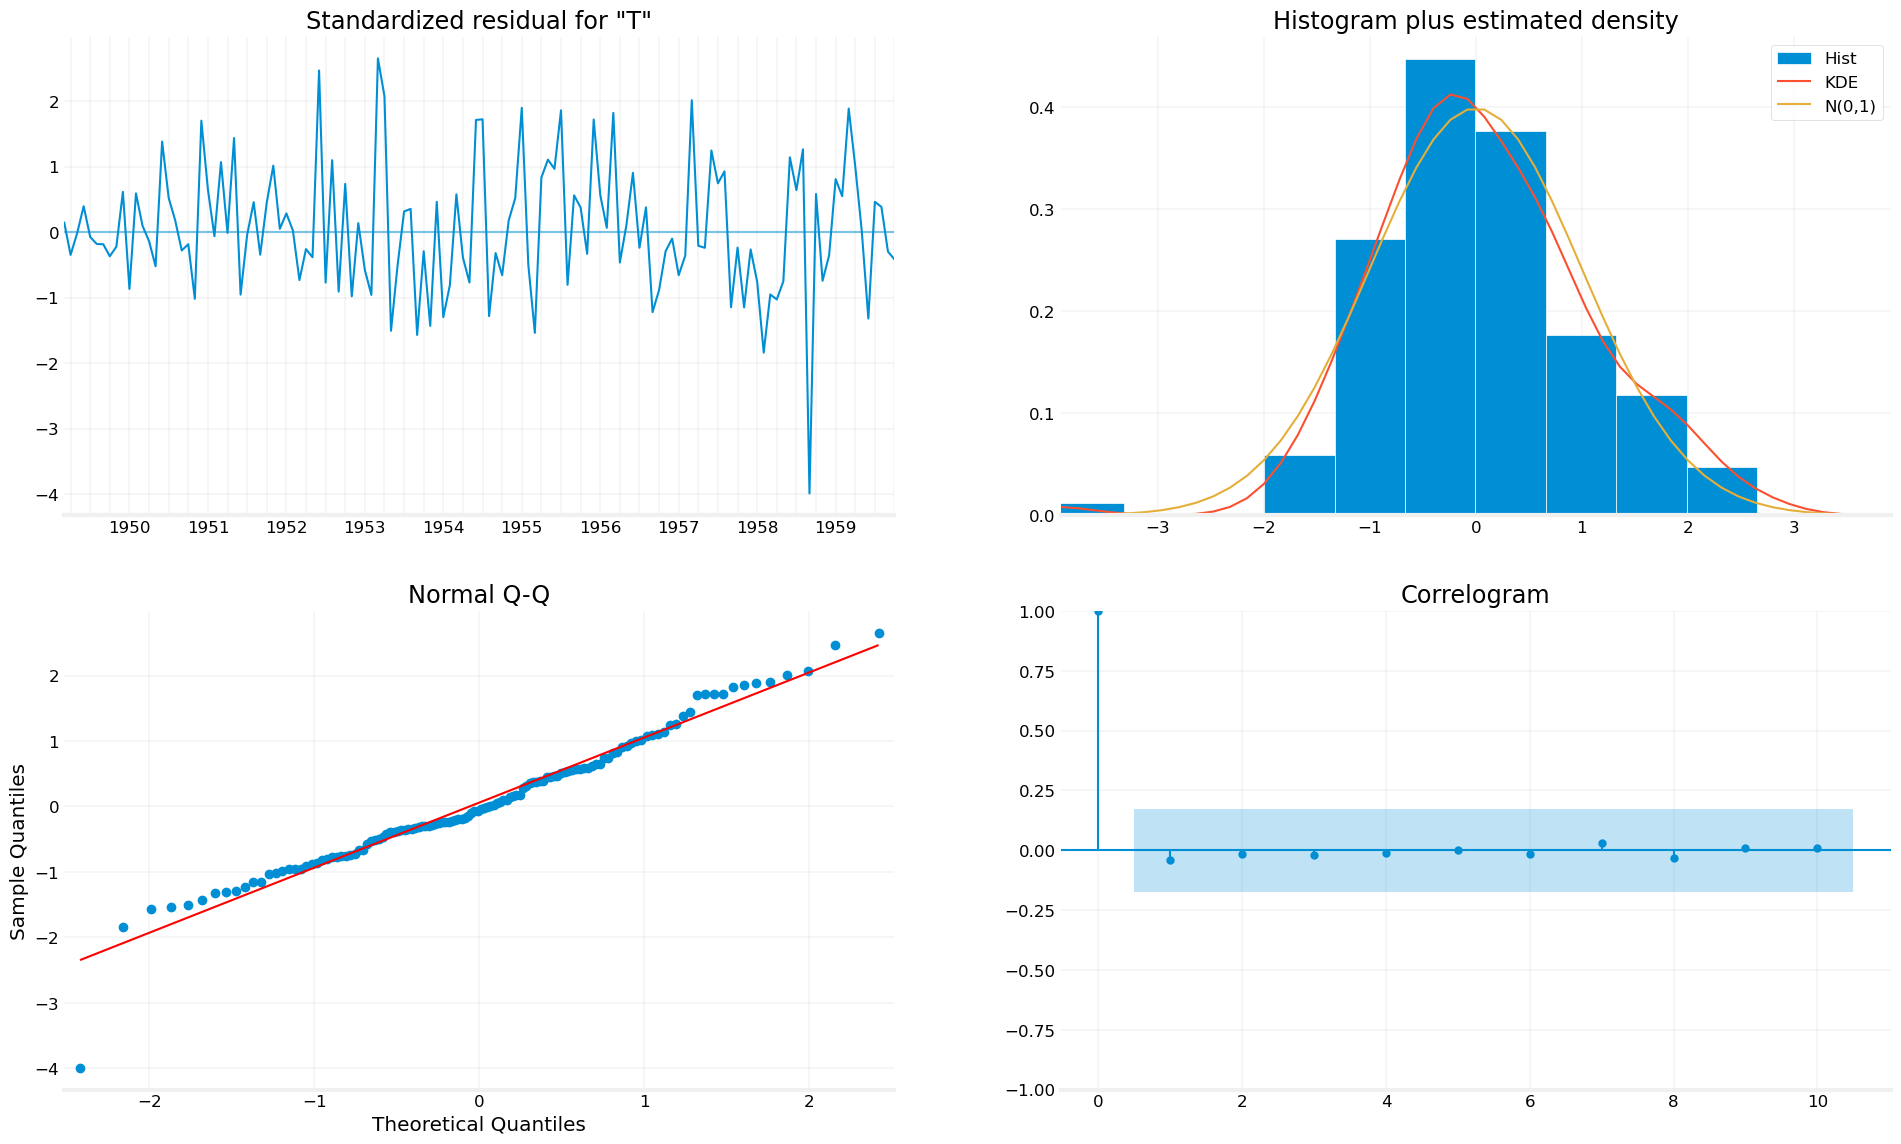

In [23]:
model_fit.plot_diagnostics();

In [24]:
PrevisoesSARIMAX = model_fit.get_prediction(len(TreinoDF), len(TreinoDF) + len(TesteDF) - 1).predicted_mean

In [25]:
# Montagem do DataFrame de previsão

PrevisoesDF  = pd.DataFrame(index = MinhaSerieTemporal[-PeriodoTeste:].index)
PrevisoesDF['Previsão'] = PrevisoesSARIMAX

<Axes: xlabel='Mês'>

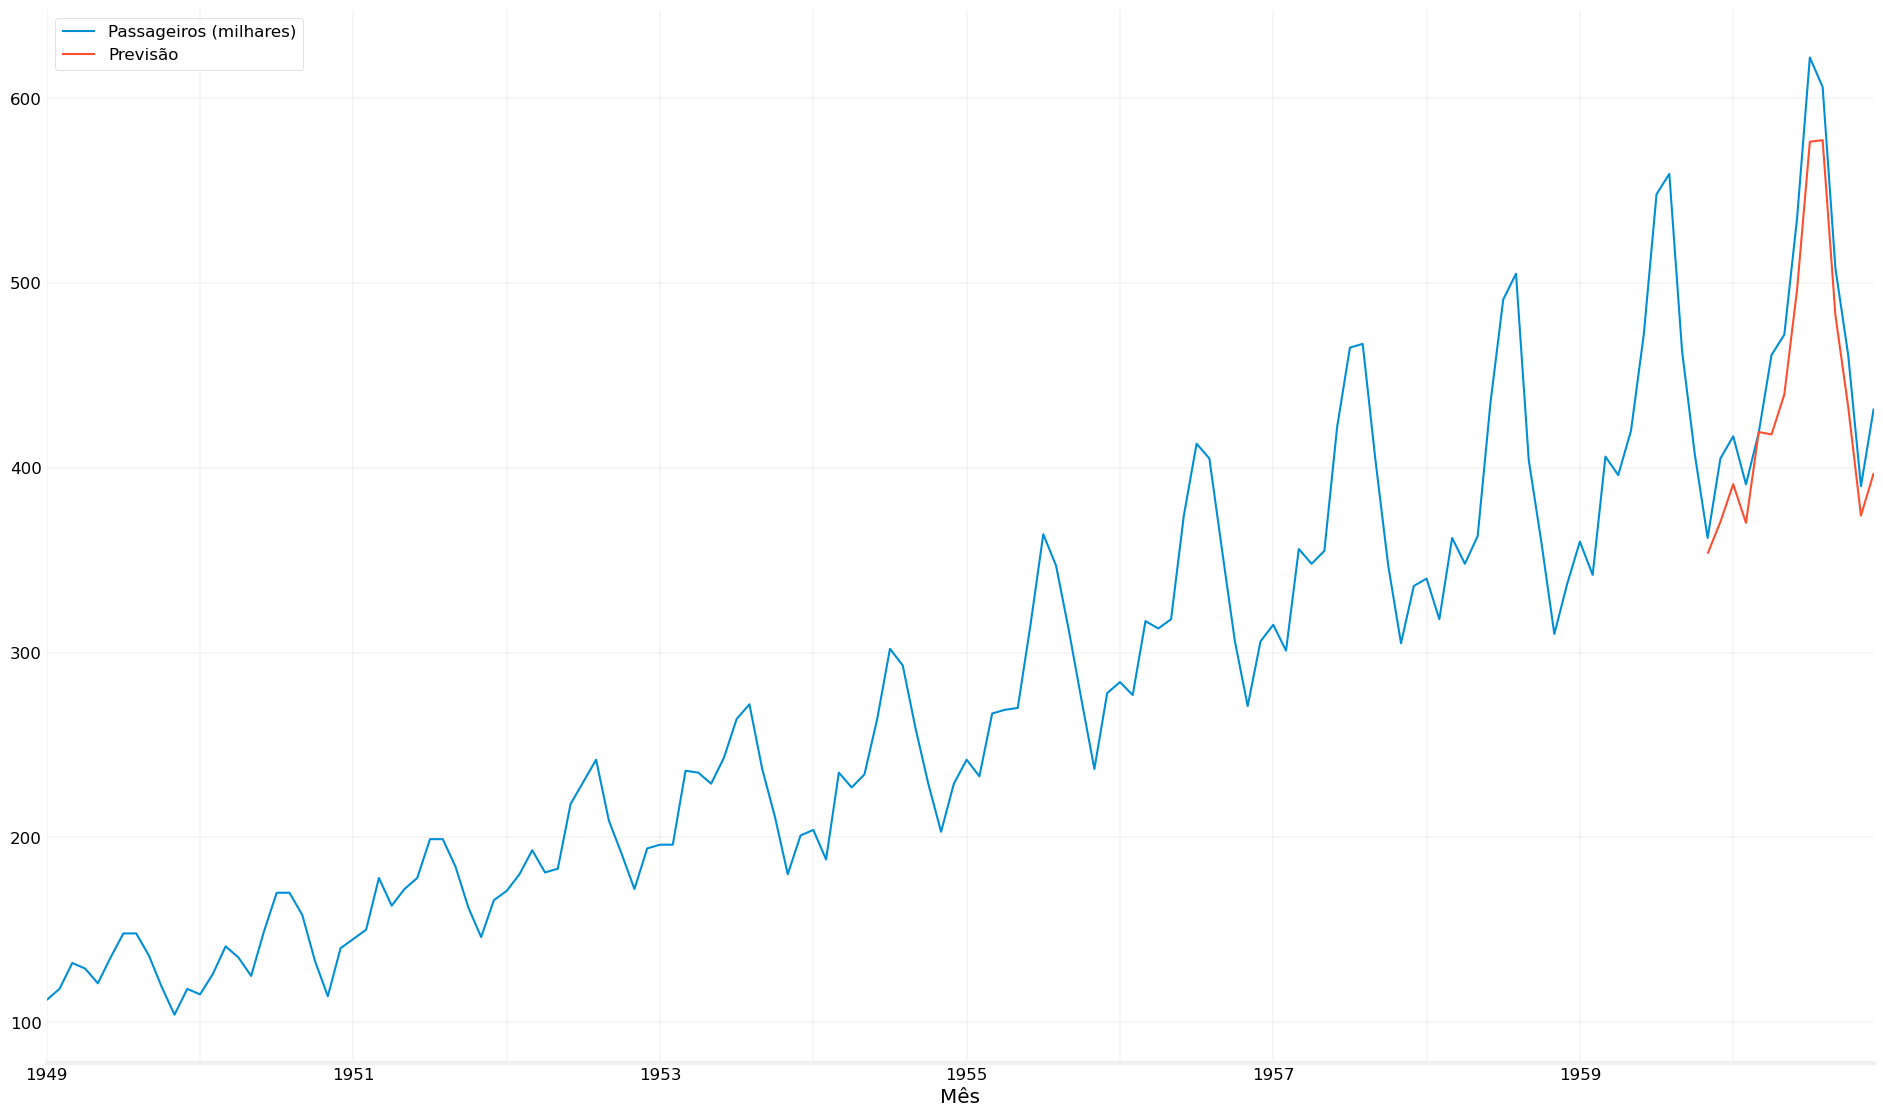

In [26]:
# Exibe a série temporal, com a separação da base de dados

pd.concat([MinhaSerieTemporal,PrevisoesDF], axis = 1).plot()

#### Medidas de erro

In [27]:
# Cáluclo do vetor de erros

Erros = PrevisoesDF['Previsão'].values - TesteDF['Teste'].values
Erros

array([ -8.50490754, -34.26480953, -25.92394675, -20.84319669,
         0.31222864, -42.98713559, -32.43781901, -38.6397861 ,
       -45.59197557, -28.7774886 , -25.44380427, -28.00792252,
       -15.88979762, -34.87414828])

In [28]:
# Cálculo do erro médio
ErroMedio = Erros.mean()

In [29]:
# Cálculo do erro absoluto médio
MAE = np.abs(Erros).mean()

In [30]:
# Cálculo da raiz do erro quadrático médio
RMSE = np.sqrt((Erros**2).mean())

In [31]:
# Cálculo dos erros relativos
ErrosRelativos = Erros / TesteDF['Teste'].values
ErrosRelativos

array([-0.02349422, -0.08460447, -0.06216774, -0.05330741,  0.00074518,
       -0.09324758, -0.06872419, -0.0722239 , -0.073299  , -0.0474876 ,
       -0.05008623, -0.06075471, -0.04074307, -0.0807272 ])

In [32]:
# Cálculo do erro percentual absoluto médio
MAPE = np.abs(ErrosRelativos).mean()

In [33]:
print(f'Medidas de erro de previsão')
print()
print(f'Modelo de previsão: ARIMA({p},{d},{q})')
print()
print(f'Erro médio: {ErroMedio: 2.1f}')
print(f'MAE:        {MAE: 2.1f}')
print(f'RMSE:       {RMSE: 2.1f}')
print(f'MAPE:       {MAPE*100: 2.1f} %')

Medidas de erro de previsão

Modelo de previsão: ARIMA(36,2,6)

Erro médio: -27.3
MAE:         27.3
RMSE:        29.9
MAPE:        5.8 %
